This notebook uses the `develop` branch of `darts`, in order to take advantage of model re-training

In [20]:
import sys

import matplotlib.pyplot as plt
import json

import dysts
from dysts.flows import *
from dysts.base import *
from dysts.utils import *
from dysts.analysis import *

# try:
#     from private.lyap import lyap_r, lyap_e, corr_dim
# except:
#     from nolds import lyap_r, lyap_e, corr_dim

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[2021-06-18 03:19:11,851] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.
[2021-06-18 03:19:11,851] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.


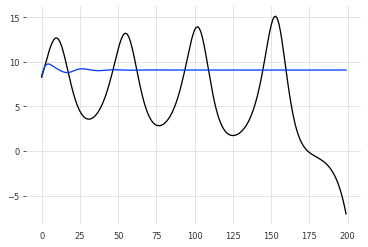

In [40]:
## Define a model that predicts a time series, given its previous values


import pandas as pd
from scipy.signal import savgol_filter

import darts 
from darts import TimeSeries
from darts.models import RNNModel

from dysts.flows import Lorenz

equation = Lorenz()
sol = equation.make_trajectory(1200, resample=True)
y_train, y_test = sol[:1000, 0], sol[1000:, 0]


try:
    del model
except:
    pass

epoch_count = 15
# model = RNNModel(50, 1, n_rnn_layers=2, n_epochs = 10)
# model = RNNModel(50, 1, model="LSTM", n_rnn_layers=2, n_epochs=100)
model = RNNModel(50, 1, model="LSTM", n_rnn_layers=2, n_epochs=epoch_count)
y_train_ts = TimeSeries.from_dataframe(pd.DataFrame(y_train))


model.fit(y_train_ts, epochs=epoch_count)
# for i in range(10):
#     model.fit(y_train_ts)
y_val_pred = model.predict(200)
y_val_pred = np.squeeze(y_val_pred.values())


## Show results
plt.plot(y_test)
plt.plot(y_val_pred)

## Find worst-performing points




In [2]:
model = RNNModel(50, 1, model="LSTM", n_rnn_layers=2, n_epochs=20)

NameError: name 'RNNModel' is not defined

In [4]:
darts.__version__

'0.8.1'

In [4]:
?model.fit

Signature:
model.fit(
    series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries]],
    covariates: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries], NoneType] = None,
    val_series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries], NoneType] = None,
    val_covariates: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries], NoneType] = None,
    verbose: bool = False,
) -> None
Docstring:
The fit method for torch models.
It wraps around `fit_from_dataset()`.

*** Currently future covariates are not yet supported ***

Parameters
----------
series
    A series or sequence of series serving as target (i.e. what the model will be trained to forecast)
covariates
    Optionally, a series or sequence of series specifying covariates
val_series
    Optionally, one or a sequence of validation target series, which will be used to compute the validation
    loss throughout training and keep track of the be

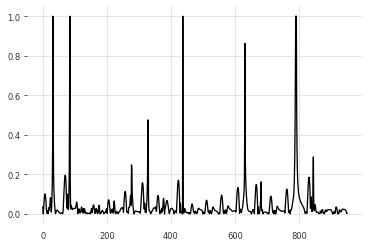

In [61]:
# # metric_calc = lambda x0, x1 :  darts.metrics.smape(TimeSeries.from_dataframe(pd.DataFrame(x0)), TimeSeries.from_dataframe(pd.DataFrame(x1))) / 200.

# def smape_indexwise(actual, predicted):
#     """
#     Calculate SMAPE at each index of two arrays
#     """
#     smape_val = np.abs(actual - predicted) / (np.abs(actual) + np.abs(predicted))
#     return smape_val





In [82]:
np.where(np.array(get_attractor_list()) == "Lorenz")

(array([63]),)

In [31]:
model.input_chunk_length

50

0


[2021-06-18 03:19:35,652] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.
[2021-06-18 03:19:35,652] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.


1


[2021-06-18 03:19:50,182] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.
[2021-06-18 03:19:50,182] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.


2


[2021-06-18 03:20:04,766] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.
[2021-06-18 03:20:04,766] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.


3


[2021-06-18 03:20:19,336] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.
[2021-06-18 03:20:19,336] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.


4


[2021-06-18 03:20:33,845] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.
[2021-06-18 03:20:33,845] INFO | darts.models.torch_forecasting_model | Train dataset contains 950 samples.


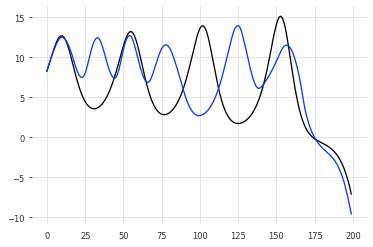

In [41]:


n_ic, n_iters = 20, 5  # model retraining is not currently working in darts
# n_ic, n_iters = 50, 1

pred_backtest = model.historical_forecasts(y_train_ts, retrain=False, start=(1 + model.input_chunk_length)/y_train.shape[0]).values()
model = RNNModel(50, 1, model="LSTM", n_rnn_layers=2, n_epochs=epoch_count)
for i in range(n_iters):
    print(i)
    
    y_train_backtest = y_train_ts.values()[-len(pred_backtest):]
    # plt.plot(smape_indexwise(pred_backtest, y_train_backtest))
    mse_back = np.squeeze(np.sqrt((pred_backtest - y_train_backtest)**2))
    sample_probs = savgol_filter(mse_back, 21, 3)
    sample_probs[sample_probs<0] = 0
    sample_probs /= np.sum(sample_probs)


    ic_indices = np.random.choice(np.arange(len(y_train_backtest)), n_ic, p=sample_probs, replace=True)
    # ic_indices = np.random.choice(np.arange(len(y_train_backtest)), n_ic)

    ic_vals = sol[ic_indices] + 1e-3 * (np.random.random(sol[ic_indices].shape) - 0.5)
    equation.ic = ic_vals
    new_sol = equation.make_trajectory(1000, resample=True)
    y_train_list = list(new_sol[..., 0])
    y_train_list = [TimeSeries.from_dataframe(pd.DataFrame(item)) for item in y_train_list]
    model.fit(y_train_ts, epochs=epoch_count)
    pred_backtest = model.historical_forecasts(y_train_ts, retrain=False, start=(1 + model.input_chunk_length)/y_train.shape[0]).values()

y_val_pred = model.predict(200)
y_val_pred = np.squeeze(y_val_pred.values())


## Show results
plt.plot(y_test)
plt.plot(y_val_pred)

In [ ]:
+ sample new ic along bad directions

In [111]:
y_train_list[0].shape

(1000,)

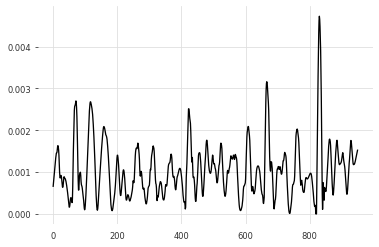

In [89]:


plt.plot(sample_probs)

In [13]:
# ?model.historical_forecasts

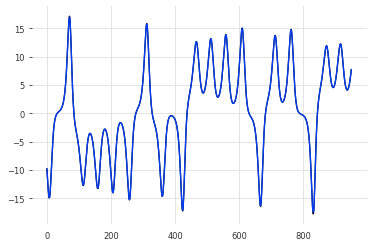

In [27]:
plt.plot(y_train_backtest)
plt.plot(pred_backtest)

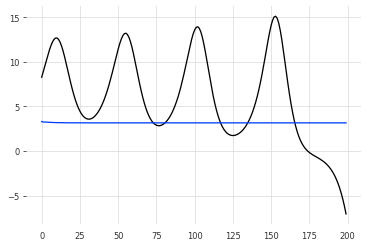

In [77]:
plt.plot(y_test)
plt.plot(y_val_pred)

In [5]:
help(model.fit)

Help on method fit in module darts.models.torch_forecasting_model:

fit(series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries]], covariates: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries], NoneType] = None, val_series: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries], NoneType] = None, val_covariates: Union[darts.timeseries.TimeSeries, Sequence[darts.timeseries.TimeSeries], NoneType] = None, verbose: bool = False) -> None method of darts.models.rnn_model.RNNModel instance
    The fit method for torch models.
    It wraps around `fit_from_dataset()`.
    
    *** Currently future covariates are not yet supported ***
    
    Parameters
    ----------
    series
        A series or sequence of series serving as target (i.e. what the model will be trained to forecast)
    covariates
        Optionally, a series or sequence of series specifying covariates
    val_series
        Optionally, one or a sequence of vali